# Jax experinment

## Sympy

### 2D Quad

In [ ]:
import sympy as sp

# Define symbols
t = sp.Symbol('t')  # time
m = sp.Symbol('m', positive=True)  # mass of the quadrotor
I = sp.Symbol('I', positive=True)  # moment of inertia
g = sp.Symbol('g', positive=True)  # gravitational acceleration
thrust = sp.Function('thrust')(t)  # thrust force
tau = sp.Function('tau')(t)  # torque

# Define state variables and their derivatives
x, y, theta = sp.symbols('x y theta', cls=sp.Function)
x = x(t)
y = y(t)
theta = theta(t)

x_dot = x.diff(t)
y_dot = y.diff(t)
theta_dot = theta.diff(t)

x_ddot = x_dot.diff(t)
y_ddot = y_dot.diff(t)
theta_ddot = theta_dot.diff(t)

# Equations of motion (Newton's second law and torque equation)
eq_x = sp.Eq(x_ddot, thrust / m * sp.sin(theta))
eq_y = sp.Eq(y_ddot, thrust / m * sp.cos(theta) - g)
eq_theta = sp.Eq(I * theta_ddot, tau)

# Solve for second-order derivatives
sol = sp.solve((eq_x, eq_y, eq_theta), (x_ddot, y_ddot, theta_ddot))
print(sol)

quadrotor_dynamics = sp.lambdify((x, y, theta, x_dot, y_dot, theta_dot, thrust, tau, m, I, g), list(sol.values()), 'jax')

### 2D Quad Rigid Rope

#### Lagrange

In [ ]:
import sympy as sp

# Define symbols
t = sp.Symbol('t')  # time
m = sp.Symbol('m', positive=True)  # mass of the quadrotor
I = sp.Symbol('I', positive=True)  # moment of inertia
g = sp.Symbol('g', positive=True)  # gravitational acceleration
l = sp.Symbol('l', positive=True)  # length of the rod
mo = sp.Symbol('mo', positive=True)  # mass of the object attached to the rod
thrust = sp.Function('thrust')(t)  # thrust force
tau = sp.Function('tau')(t)  # torque
delta_xh = sp.Symbol('delta_xh')  # x displacement of the hook from the quadrotor center
delta_yh = sp.Symbol('delta_yh')  # y displacement of the hook from the quadrotor center

# Define state variables and their derivatives
x, y, theta, phi = sp.symbols('x y theta phi', cls=sp.Function)
x = x(t)
y = y(t)
theta = theta(t)
phi = phi(t)

x_dot = x.diff(t)
y_dot = y.diff(t)
theta_dot = theta.diff(t)
phi_dot = phi.diff(t)

# Define positions of the hook and the object attached to the rod
x_hook = x + delta_xh * sp.cos(theta) - delta_yh * sp.sin(theta)
y_hook = y + delta_xh * sp.sin(theta) + delta_yh * sp.cos(theta)

x_obj = x_hook + l * sp.sin(phi)
y_obj = y_hook - l * sp.cos(phi)

x_obj_dot = x_obj.diff(t)
y_obj_dot = y_obj.diff(t)

# Define the Lagrangian
T = 1/2 * m * (x_dot**2 + y_dot**2) + 1/2 * I * theta_dot**2 + 1/2 * mo * (x_obj_dot**2 + y_obj_dot**2)
V = m * g * y + mo * g * y_obj
L = T - V

# Compute the Euler-Lagrange equations
LE_x = sp.diff(L.diff(x_dot), t) - L.diff(x)
LE_y = sp.diff(L.diff(y_dot), t) - L.diff(y)
LE_theta = sp.diff(L.diff(theta_dot), t) - L.diff(theta)
LE_phi = sp.diff(L.diff(phi_dot), t) - L.diff(phi)

# simplify the function
LE_x = sp.simplify(LE_x - thrust * sp.sin(theta))
LE_y = sp.simplify(LE_y - thrust * sp.cos(theta) + m * g + mo * g)
LE_theta = sp.simplify(LE_theta - tau)
LE_phi = sp.simplify(LE_phi)

# Solve for second-order derivatives
sol = sp.solve((LE_x, LE_y, LE_theta, LE_phi), (x_dot.diff(t), y_dot.diff(t), theta_dot.diff(t), phi_dot.diff(t)), simplify=False) # NOTE disable simplify to make it faster. 
print(sol)

quadrotor_dynamics = sp.lambdify((x, y, theta, phi, x_dot, y_dot, theta_dot, phi_dot, thrust, tau, m, I, g, l, mo, delta_xh, delta_yh), list(sol.values()), 'jax')

#### Kane

In [3]:
import sympy as sp
from sympy.physics.mechanics import (
    dynamicsymbols,
    ReferenceFrame,
    Point,
    Particle,
    RigidBody,
    inertia,
    KanesMethod,
)
from jax import numpy as jnp

'''
z
^
| - > y
. x
'''

# Define symbols
t = sp.Symbol("t")  # time
m = sp.Symbol("m", positive=True)  # mass of the quadrotor
I = sp.Symbol("I", positive=True)  # moment of inertia
g = sp.Symbol("g", positive=True)  # gravitational acceleration
l = sp.Symbol("l", positive=True)  # length of the rod
mo = sp.Symbol("mo", positive=True)  # mass of the object attached to the rod
thrust = sp.Function("thrust")(t)  # thrust force
tau = sp.Function("tau")(t)  # torque
delta_yh = sp.Symbol("delta_yh")  # y displacement of the hook from the quadrotor center
delta_zh = sp.Symbol("delta_zh")  # z displacement of the hook from the quadrotor center

# Define state variables and their derivatives
y, z, theta, phi = dynamicsymbols("y z theta phi")
y_dot, z_dot, theta_dot, phi_dot = dynamicsymbols("y_dot z_dot theta_dot phi_dot")

N = ReferenceFrame("N")
A = N.orientnew("A", "Axis", [theta, N.x])
B = N.orientnew("B", "Axis", [phi, A.x])

# Define positions of the hook and the object attached to the rod
O = Point("O")
O.set_pos(O, y * N.y + z * N.z)
hook = O.locatenew("hook", delta_yh * A.y + delta_zh * A.z)
obj = hook.locatenew("obj", -l * B.z)

# Define velocities
O.set_vel(N, y_dot * N.y + z_dot * N.z)
hook.v2pt_theory(O, N, A)
obj.v2pt_theory(hook, N, B)

# Kinematic Differential Equations (KDEs)
kde = [
    y_dot - y.diff(t),
    z_dot - z.diff(t),
    theta_dot - theta.diff(t),
    phi_dot - phi.diff(t),
]

# Inertia
inertia_quadrotor = inertia(N, I, 0, 0)
quadrotor = RigidBody("quadrotor", O, A, m, (inertia_quadrotor, O))
obj_particle = Particle("obj_particle", obj, mo)

# Forces
forces = [(O, thrust * A.z), (O, -m * g * N.z), (obj, -mo * g * N.z), (A, tau * N.x)]

# Kane's equations
kane = KanesMethod(
    N, q_ind=(y, z, theta, phi), u_ind=(y_dot, z_dot, theta_dot, phi_dot), kd_eqs=kde
)
fr, fr_star = kane.kanes_equations(loads=forces, bodies=[quadrotor, obj_particle])
f = fr + fr_star

# Linearization
# Define the unknown derivatives
phi_ddot = sp.Derivative(phi_dot, t)
theta_ddot = sp.Derivative(theta_dot, t)
y_ddot = sp.Derivative(y_dot, t)
z_ddot = sp.Derivative(z_dot, t)
# Collect the coefficients of the unknown derivatives in each equation
A = sp.Matrix(
    [
        [
            f[0].coeff(phi_ddot),
            f[0].coeff(theta_ddot),
            f[0].coeff(y_ddot),
            f[0].coeff(z_ddot),
        ],
        [
            f[1].coeff(phi_ddot),
            f[1].coeff(theta_ddot),
            f[1].coeff(y_ddot),
            f[1].coeff(z_ddot),
        ],
        [
            f[2].coeff(phi_ddot),
            f[2].coeff(theta_ddot),
            f[2].coeff(y_ddot),
            f[2].coeff(z_ddot),
        ],
        [
            f[3].coeff(phi_ddot),
            f[3].coeff(theta_ddot),
            f[3].coeff(y_ddot),
            f[3].coeff(z_ddot),
        ],
    ]
)
# Define the constant column vector b
b = sp.Matrix(
    [
        f[0].subs({phi_ddot: 0, theta_ddot: 0, y_ddot: 0, z_ddot: 0}),
        f[1].subs({phi_ddot: 0, theta_ddot: 0, y_ddot: 0, z_ddot: 0}),
        f[2].subs({phi_ddot: 0, theta_ddot: 0, y_ddot: 0, z_ddot: 0}),
        f[3].subs({phi_ddot: 0, theta_ddot: 0, y_ddot: 0, z_ddot: 0}),
    ]
)
# print A and b in a nice format
# sp.pprint(A)
# sp.pprint(b)

# Define the variables for lambdify
variables = (
    phi,
    theta,
    y,
    z,
    phi_dot,
    theta_dot,
    y_dot,
    z_dot,
    m,
    I,
    g,
    l,
    mo,
    thrust,
    tau,
    delta_yh,
    delta_zh,
)

# Lambdify A and b
A_func = sp.lambdify(variables, A, "jax")
b_func = sp.lambdify(variables, b, "jax")


# Define the function to compute A^-1 (x-b)
def quadrotor_dynamics_kane(
    phi_val,
    theta_val,
    y_val,
    z_val,
    phi_dot_val,
    theta_dot_val,
    y_dot_val,
    z_dot_val,
    m_val,
    I_val,
    g_val,
    l_val,
    mo_val,
    thrust_val,
    tau_val,
    delta_yh_val,
    delta_zh_val,
):
    # return phi_ddot, theta_ddot, y_ddot, z_ddot
    A_val = A_func(
        phi_val,
        theta_val,
        y_val,
        z_val,
        phi_dot_val,
        theta_dot_val,
        y_dot_val,
        z_dot_val,
        m_val,
        I_val,
        g_val,
        l_val,
        mo_val,
        thrust_val,
        tau_val,
        delta_yh_val,
        delta_zh_val,
    )
    b_val = b_func(
        phi_val,
        theta_val,
        y_val,
        z_val,
        phi_dot_val,
        theta_dot_val,
        y_dot_val,
        z_dot_val,
        m_val,
        I_val,
        g_val,
        l_val,
        mo_val,
        thrust_val,
        tau_val,
        delta_yh_val,
        delta_zh_val,
    )
    return jnp.linalg.solve(A_val, -b_val).squeeze()

In [ ]:
sp.pprint(f[0])

#### Newton

In [ ]:
import sympy as sp

# Define symbols
t = sp.Symbol('t')  # time
m = sp.Symbol('m', positive=True)  # mass of the quadrotor
I = sp.Symbol('I', positive=True)  # moment of inertia
g = sp.Symbol('g', positive=True)  # gravitational acceleration
l = sp.Symbol('l', positive=True)  # length of the rod
mo = sp.Symbol('mo', positive=True)  # mass of the object attached to the rod
thrust = sp.Function('thrust')(t)  # thrust force
tau = sp.Function('tau')(t)  # torque
T = sp.Symbol('T')  # rope force
delta_xh = sp.Symbol('delta_xh')  # x displacement of the hook from the quadrotor center
delta_yh = sp.Symbol('delta_yh')  # y displacement of the hook from the quadrotor center

# Define state variables and their derivatives
x, y, theta, phi = sp.symbols('x y theta phi', cls=sp.Function)
x = x(t)
y = y(t)
theta = theta(t)
phi = phi(t)

x_dot = x.diff(t)
y_dot = y.diff(t)
theta_dot = theta.diff(t)
phi_dot = phi.diff(t)

# Define positions of the hook and the object attached to the rod
# Convert local hook displacement to global frame
delta_xh_global = delta_xh * sp.cos(theta) - delta_yh * sp.sin(theta)
delta_yh_global = delta_xh * sp.sin(theta) + delta_yh * sp.cos(theta)
x_hook = x + delta_xh_global
y_hook = y + delta_yh_global

x_obj = x_hook + l * sp.sin(phi)
y_obj = y_hook - l * sp.cos(phi)

x_obj_dot = x_obj.diff(t)
y_obj_dot = y_obj.diff(t)

# Linear accelerations
a_x_quad = x_dot.diff(t)
a_y_quad = y_dot.diff(t)
a_x_obj = x_obj_dot.diff(t)
a_y_obj = y_obj_dot.diff(t)

# Angular acceleration
phi_ddot = phi_dot.diff(t)

# Newton's second law for linear motion of quadrotor
F_x_quad = thrust * sp.sin(theta) - m * a_x_quad - T * sp.sin(phi)
F_y_quad = thrust * sp.cos(theta) - m * a_y_quad + m * g - T * sp.cos(phi)

# Newton's second law for linear motion of object
F_x_obj = mo * a_x_obj + T * sp.sin(phi)
F_y_obj = mo * a_y_obj - mo * g + T * sp.cos(phi)

# Euler's equations for angular motion of rod
M_phi = delta_xh_global * (- T * sp.cos(phi)) - delta_yh_global * (- T * sp.sin(phi)) - I * theta_dot.diff(t)

# Equations of motion
eq1 = F_x_quad
eq2 = F_y_quad
eq3 = F_x_obj
eq4 = F_y_obj
eq5 = M_phi

# Solve for second-order derivatives and rope tension
sol_NE = sp.solve((eq1, eq2, eq3, eq4, eq5), (x_dot.diff(t), y_dot.diff(t), theta_dot.diff(t), phi_dot.diff(t), T))
print(sol_NE)

# Simplify the solutions
sol_NE_simplified = {key: sp.simplify(value) for key, value in sol_NE.items()}
print(sol_NE_simplified)

# Create a function for the second-order derivatives and rope tension
quadrotor_dynamics_NE = sp.lambdify((x, y, theta, phi, x_dot, y_dot, theta_dot, phi_dot, thrust, tau, m, I, g, l, mo, delta_xh, delta_yh), list(sol_NE_simplified.values()), 'jax')

## Environment

In [28]:
import jax
import jax.numpy as jnp
from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
import chex
from flax import struct


@struct.dataclass
class EnvState:
    y: float
    z: float
    theta: float
    phi: float
    y_dot: float
    z_dot: float
    theta_dot: float
    phi_dot: float
    last_thrust: float  # Only needed for rendering
    last_tau: float  # Only needed for rendering
    time: int
    y_traj: jnp.ndarray
    z_traj: jnp.ndarray
    y_dot_traj: jnp.ndarray
    z_dot_traj: jnp.ndarray
    y_tar: float
    z_tar: float
    y_dot_tar: float
    z_dot_tar: float


@struct.dataclass
class EnvParams:
    max_speed: float = 8.0
    max_torque: float = 0.01
    max_thrust: float = 0.4
    dt: float = 0.02
    g: float = 9.81  # gravity
    m: float = 0.03  # mass
    I: float = 2.0e-5  # moment of inertia
    mo: float = 0.005  # mass of the object attached to the rod
    l: float = 0.3  # length of the rod
    delta_yh: float = 0.03  # y displacement of the hook from the quadrotor center
    delta_zh: float = -0.05  # z displacement of the hook from the quadrotor center
    max_steps_in_episode: int = 200


class Quad2D(environment.Environment):
    """
    JAX Compatible version of Quad2D-v0 OpenAI gym environment. Source:
    github.com/openai/gym/blob/master/gym/envs/classic_control/Quad2D.py
    """

    def __init__(self):
        super().__init__()
        self.obs_shape = (16,)

    @property
    def default_params(self) -> EnvParams:
        """Default environment parameters for Quad2D-v0."""
        return EnvParams()

    def step_env(
        self,
        key: chex.PRNGKey,
        state: EnvState,
        action: float,
        params: EnvParams,
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        """Integrate Quad2D ODE and return transition."""
        thrust = (action[0] + 1.0) / 2.0 * params.max_thrust
        tau = action[1] * params.max_torque
        reward = 1.0 - (
            0.8
            * jnp.sqrt(
                (state.y_tar - state.y) ** 2 + (state.z_tar - state.z) ** 2
            )  # close to center
            + 0.03
            * jnp.sqrt(
                (state.y_dot_tar - state.y_dot) ** 2
                + (state.z_dot_tar - state.z_dot) ** 2
            )  # zero velocity
        )
        reward = reward.squeeze()

        s_dot = quadrotor_dynamics_kane(
            state.phi,
            state.theta,
            state.y,
            state.z,
            state.phi_dot,
            state.theta_dot,
            state.y_dot,
            state.z_dot,
            params.m,
            params.I,
            params.g,
            params.l,
            params.mo,
            thrust,
            tau,
            params.delta_yh,
            params.delta_zh,
        )

        new_y_dot = state.y_dot + params.dt * s_dot[2]
        new_z_dot = state.z_dot + params.dt * s_dot[3]
        new_th_dot = state.theta_dot + params.dt * s_dot[1]
        new_phi_dot = state.phi_dot + params.dt * s_dot[0]
        new_y = state.y + params.dt * new_y_dot
        new_z = state.z + params.dt * new_z_dot
        new_th = angle_normalize(state.theta + params.dt * new_th_dot)
        new_phi = angle_normalize(state.phi + params.dt * new_phi_dot)

        # Update state dict and evaluate termination conditions
        time = state.time + 1
        state = EnvState(
            y=new_y,
            z=new_z,
            y_dot=new_y_dot,
            z_dot=new_z_dot,
            theta=new_th,
            theta_dot=new_th_dot,
            last_thrust=thrust,
            last_tau=tau,
            time=time,
            y_traj=state.y_traj,
            z_traj=state.z_traj,
            y_dot_traj=state.y_dot_traj,
            z_dot_traj=state.z_dot_traj,
            y_tar=state.y_traj[time],
            z_tar=state.z_traj[time],
            y_dot_tar=state.y_dot_traj[time],
            z_dot_tar=state.z_dot_traj[time],
            phi=new_phi,
            phi_dot=new_phi_dot,
        )
        done = self.is_terminal(state, params)
        return (
            lax.stop_gradient(self.get_obs(state)),
            lax.stop_gradient(state),
            reward,
            done,
            {"discount": self.discount(state, params)},
        )

    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Reset environment state by sampling theta, theta_dot."""
        high = jnp.array([1, 1, jnp.pi / 3])
        rand_val = jax.random.uniform(key, shape=(3,), minval=-high, maxval=high)

        # generate reference trajectory by adding a few sinusoids together
        # get random attitude and phase
        key_amp_y, key_phase_y, key_amp_z, key_phase_z = jax.random.split(key, 4)
        rand_amp_y = jax.random.uniform(key_amp_y, shape=(2,), minval=-1.0, maxval=1.0)
        rand_amp_z = jax.random.uniform(key_amp_z, shape=(2,), minval=-1.0, maxval=1.0)
        rand_phase_y = jax.random.uniform(key_phase_y, shape=(2,), minval=-jnp.pi, maxval=jnp.pi)
        rand_phase_z = jax.random.uniform(key_phase_z, shape=(2,), minval=-jnp.pi, maxval=jnp.pi)

        # get trajectory
        scale = 1.0
        ts = jnp.arange(
            0, self.default_params.max_steps_in_episode, self.default_params.dt
        )  # NOTE: do not use params for jax limitation
        w1 = 2 * jnp.pi * 0.25
        w2 = 2 * jnp.pi * 0.5
        y_traj = scale * rand_amp_y[0] * jnp.sin(
            w1 * ts + rand_phase_y[0]
        ) + scale * rand_amp_y[1] * jnp.sin(w2 * ts + rand_phase_y[1])
        z_traj = scale * rand_amp_z[0] * jnp.sin(
            w1 * ts + rand_phase_z[0]
        ) + scale * rand_amp_z[1] * jnp.sin(w2 * ts + rand_phase_z[1])
        y_dot_traj = scale * rand_amp_y[0] * w1 * jnp.cos(
            w1 * ts + rand_phase_y[0]
        ) + scale * rand_amp_y[1] * w2 * jnp.cos(w2 * ts + rand_phase_y[1])
        z_dot_traj = scale * rand_amp_z[0] * w1 * jnp.cos(
            w1 * ts + rand_phase_z[0]
        ) + scale * rand_amp_z[1] * w2 * jnp.cos(w2 * ts + rand_phase_z[1])

        state = EnvState(
            y=rand_val[0],
            z=rand_val[1],
            theta=rand_val[2],
            y_dot=0.0,
            z_dot=0.0,
            theta_dot=0.0,
            last_thrust=0.0,
            last_tau=0.0,
            time=0,
            y_traj=y_traj,
            z_traj=z_traj,
            y_dot_traj=y_dot_traj,
            z_dot_traj=z_dot_traj,
            y_tar=y_traj[0],
            z_tar=z_traj[0],
            y_dot_tar=y_dot_traj[0],
            z_dot_tar=z_dot_traj[0],
            phi=0.0,
            phi_dot=0.0,
        )

        return self.get_obs(state), state

    def get_obs(self, state: EnvState) -> chex.Array:
        """Return angle in polar coordinates and change."""
        return jnp.array(
            [
                state.y,
                state.z,
                state.theta,
                state.y_dot / 4.0,
                state.z_dot / 4.0,
                state.theta_dot / 40.0,
                state.y_tar,
                state.z_tar,
                state.y_dot_tar / 4.0,
                state.z_dot_tar / 4.0,
                state.y_tar - state.y,
                state.z_tar - state.z,
                (state.y_dot_tar - state.y_dot) / 4.0,
                (state.z_dot_tar - state.z_dot) / 4.0,
                state.phi,
                state.phi_dot / 10.0,
            ]
        ).squeeze()

    def is_terminal(self, state: EnvState, params: EnvParams) -> bool:
        """Check whether state is terminal."""
        # Check number of steps in episode termination condition
        done = (
            (state.time >= params.max_steps_in_episode)
            | (jnp.abs(state.y) > 2.0)
            | (jnp.abs(state.z) > 2.0)
        )
        return done

    @property
    def name(self) -> str:
        """Environment name."""
        return "Quad2D-v1"

    @property
    def num_actions(self) -> int:
        """Number of actions possible in environment."""
        return 2

    def action_space(self, params: Optional[EnvParams] = None) -> spaces.Box:
        """Action space of the environment."""
        if params is None:
            params = self.default_params
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(2,),
            dtype=jnp.float32,
        )

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        high = jnp.array(
            [
                1.0,
                1.0,
                jnp.pi,
                4.0,
                4.0,
                40.0,
                1.0,
                1.0,
                4.0,
                4.0,
                1.0,
                1.0,
                4.0,
                4.0,
                jnp.pi,
                10.0,
            ],
            dtype=jnp.float32,
        )
        return spaces.Box(-high, high, shape=(16,), dtype=jnp.float32)

    def state_space(self, params: EnvParams) -> spaces.Dict:
        """State space of the environment."""
        return spaces.Dict(
            {
                "y": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "z": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "y_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "z_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "theta": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "theta_dot": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "last_thrust": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "last_tau": spaces.Box(
                    -jnp.finfo(jnp.float32).max,
                    jnp.finfo(jnp.float32).max,
                    (),
                    jnp.float32,
                ),
                "time": spaces.Discrete(params.max_steps_in_episode),
            }
        )


def angle_normalize(x: float) -> float:
    """Normalize the angle - radians."""
    return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi

### Test Env

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_309099/2903392319.py:130: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


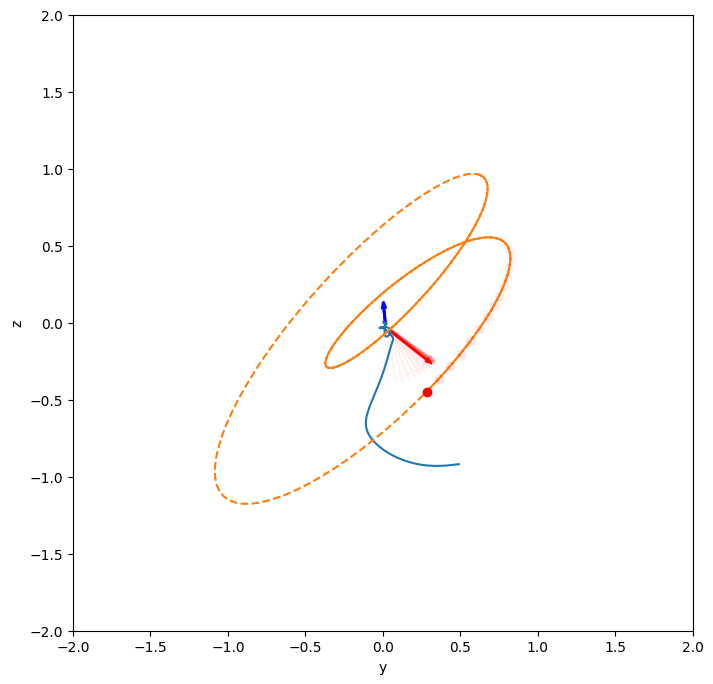

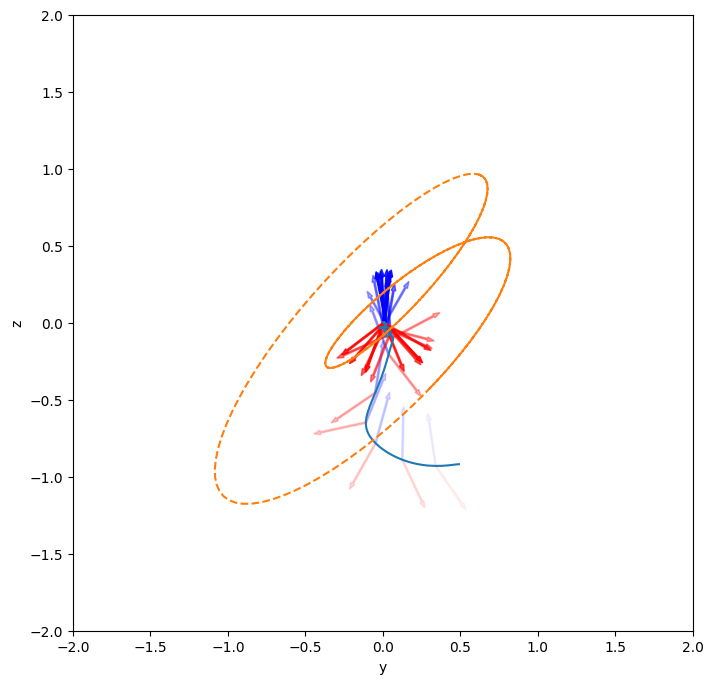

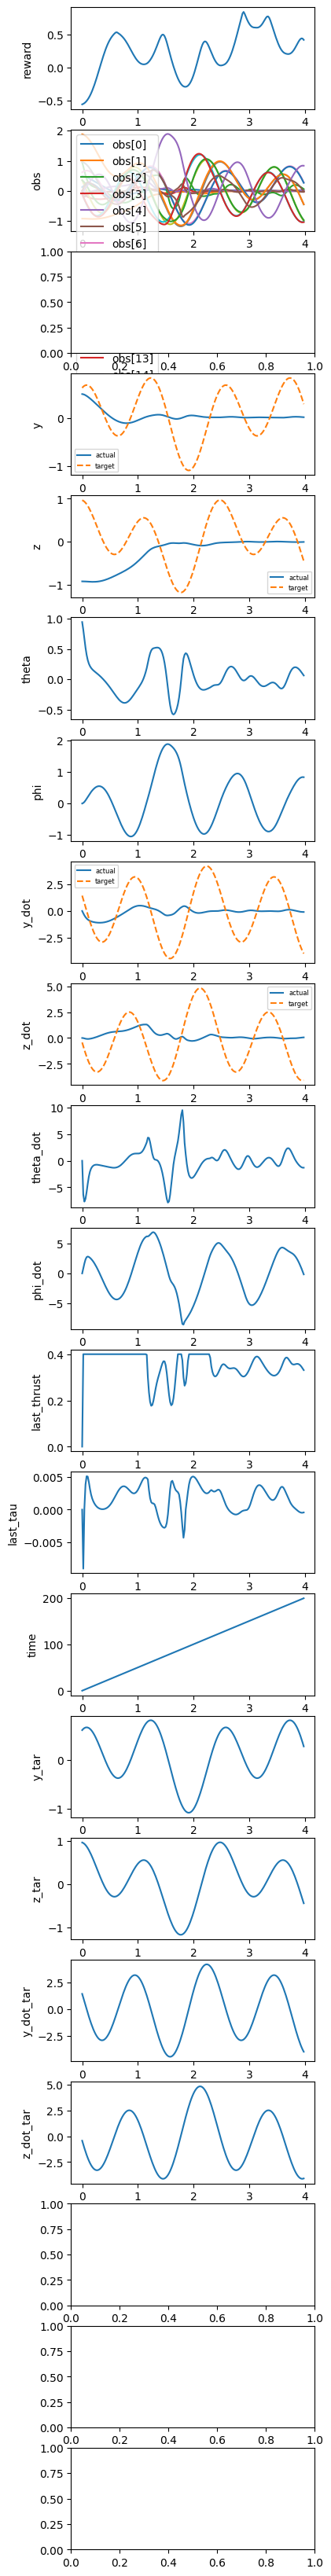

In [35]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def test_env(env: Quad2D, policy):
    env_params = env.default_params
    rng = jax.random.PRNGKey(3)

    state_seq, obs_seq, reward_seq = [], [], []
    rng, rng_reset = jax.random.split(rng)
    obs, env_state = env.reset(rng_reset, env_params)
    n_dones = 0
    while True:
        state_seq.append(env_state)
        rng, rng_act, rng_step = jax.random.split(rng, 3)
        action = policy(obs, rng_act)
        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, env_state, action, env_params
        )
        reward_seq.append(reward)
        obs_seq.append(obs)
        if done:
            n_dones += 1
        obs = next_obs
        env_state = next_env_state
        if n_dones >= 1:
            break

    # plot trajectory
    def update_plot(frame_num):
        plt.gca().clear()
        plt.plot([s.y for s in state_seq[0:frame_num+1]], [s.z for s in state_seq[0:frame_num+1]])
        plt.plot([s.y_tar for s in state_seq[0:frame_num+1]], [s.z_tar for s in state_seq[0:frame_num+1]], "--")
        
        start = max(0, frame_num - 19)
        for i in range(start, frame_num + 1):
            num_steps = max(frame_num - start, 1)
            alpha = 1 if i == frame_num else ((i-start) / num_steps * 0.1)
            plt.arrow(
                state_seq[i].y,
                state_seq[i].z,
                -0.1 * jnp.sin(state_seq[i].theta),
                0.1 * jnp.cos(state_seq[i].theta),
                width=0.01,
                color="b",
                alpha=alpha,
            )
            theta = state_seq[i].theta
            y_hook = state_seq[i].y + env_params.delta_yh * jnp.cos(theta) - env_params.delta_zh * jnp.sin(theta)
            z_hook = state_seq[i].z + env_params.delta_yh * jnp.sin(theta) + env_params.delta_zh * jnp.cos(theta)
            plt.arrow(
                y_hook,
                z_hook,
                env_params.l * jnp.sin(state_seq[i].phi+state_seq[i].theta),
                -env_params.l * jnp.cos(state_seq[i].phi+state_seq[i].theta),
                width=0.01,
                color="r",
                alpha=alpha,
            )
            # plot y_tar and z_tar with red dot
            plt.plot(state_seq[i].y_tar, state_seq[i].z_tar, "ro", alpha=alpha)
        plt.xlabel("y")
        plt.ylabel("z")
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])

    plt.figure(figsize=(8, 8))
    anim = FuncAnimation(plt.gcf(), update_plot, frames=len(state_seq), interval=20)
    anim.save(filename="../results/anim.gif", writer="imagemagick", fps=int(1.0/env_params.dt))

    # plot quadrotor trajectory with orientation represented as arrow
    plt.figure(figsize=(8, 8))
    plt.plot([s.y for s in state_seq], [s.z for s in state_seq])
    plt.plot([s.y_tar for s in state_seq], [s.z_tar for s in state_seq], "--")
    for i in range(len(state_seq)):
        if i % 10 != 0:
            continue
        # change capacity over time
        plt.arrow(
            state_seq[i].y,
            state_seq[i].z,
            -0.3 * jnp.sin(state_seq[i].theta),
            0.3 * jnp.cos(state_seq[i].theta),
            width=0.01,
            color="b",
            alpha=i / len(state_seq),
        )
        plt.arrow(
            state_seq[i].y,
            state_seq[i].z,
            env_params.l * jnp.sin(state_seq[i].phi+state_seq[i].theta),
            -env_params.l * jnp.cos(state_seq[i].phi+state_seq[i].theta),
            width=0.01,
            color="r",
            alpha=i / len(state_seq),
        )
    plt.xlabel("y")
    plt.ylabel("z")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])

    num_figs = len(state_seq[0].__dict__) + 2
    time = [s.time * env_params.dt for s in state_seq]
    # create num_figs subplots
    plt.subplots(num_figs, 1, figsize=(4, 2 * num_figs))
    # plot reward
    plt.subplot(num_figs, 1, 1)
    plt.plot(time, reward_seq)
    plt.ylabel("reward")
    # plot obs
    plt.subplot(num_figs, 1, 2)
    for i in range(len(obs_seq[0])):
        plt.plot(time, [o[i] for o in obs_seq], label=f"obs[{i}]")
    plt.ylabel("obs")
    plt.legend()

    # plot state
    current_fig = 3
    for i, (name, value) in enumerate(state_seq[0].__dict__.items()):
        if name in ["y_traj", "z_traj", "y_dot_traj", "z_dot_traj", "theta_traj"]:
            continue
        current_fig += 1
        plt.subplot(num_figs, 1, current_fig)
        plt.plot(time, [getattr(s, name) for s in state_seq])
        if name in ["y", "z", "y_dot", "z_dot"]:
            plt.plot(time, [s.__dict__[name + "_tar"] for s in state_seq], "--")
            plt.legend(["actual", "target"], fontsize=6)
        plt.ylabel(name)

    plt.xlabel("time")
    plt.tight_layout()
    plt.savefig("../results/plot.png")
    plt.show()

env = Quad2D()
random_policy = lambda obs, rng: env.action_space(env.default_params).sample(rng)

def pid_policy(obs, rng):
    y = obs[0]
    z = obs[1]
    theta = obs[2]
    y_dot = obs[3] * 4.0
    z_dot = obs[4] * 4.0
    theta_dot = obs[5] * 40.0
    y_tar = obs[6] * 0.0 # DEBUG
    z_tar = obs[7] * 0.0
    y_dot_tar = obs[8] * 4.0 * 0.0
    z_dot_tar = obs[9] * 4.0 * 0.0

    w0 = 10.0
    zeta = 0.95
    kp = env.default_params.m * (w0**2)
    kd = env.default_params.m * 2.0 * zeta * w0
    target_force_y = kp * (y_tar - y) + kd * (y_dot_tar - y_dot)
    target_force_z = (
        kp * (z_tar - z)
        + kd * (z_dot_tar - z_dot)
        + (env.default_params.m + env.default_params.mo) * env.default_params.g
    )
    thrust = target_force_y * jnp.sin(theta) + target_force_z * jnp.cos(theta)
    target_theta = -jnp.arctan2(target_force_y, target_force_z)

    w0 = 30.0
    zeta = 1.0
    tau = env.default_params.I * (
        (w0**2) * (target_theta - theta) + 2.0 * zeta * w0 * (0.0 - theta_dot)
    )

    # convert into action space
    thrust_normed = jnp.clip(
        thrust / env.default_params.max_thrust * 2.0 - 1.0, -1.0, 1.0
    )
    tau_normed = jnp.clip(tau / env.default_params.max_torque, -1.0, 1.0)
    return jnp.array([thrust_normed, tau_normed])


with jax.disable_jit():
    test_env(env, policy=pid_policy)

## Train

### make function

In [30]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.environments import environment, spaces
from brax.envs.wrappers import training
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param('log_std', nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env= Quad2D()
    env_params = env.default_params 
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space(env_params).shape[0], activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0,None))(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


In [31]:
config = {
    "LR": 3e-4,
    "NUM_ENVS": 2048,
    "NUM_STEPS": 200,
    "TOTAL_TIMESTEPS": 2e7,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 320,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ANNEAL_LR": False,
}

### train

In [32]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
train_jit = jax.jit(make_train(config))
print(f"jit time: {time.time() - t0:.2f} s")

jit time: 0.00 s


train time: 36.46 s


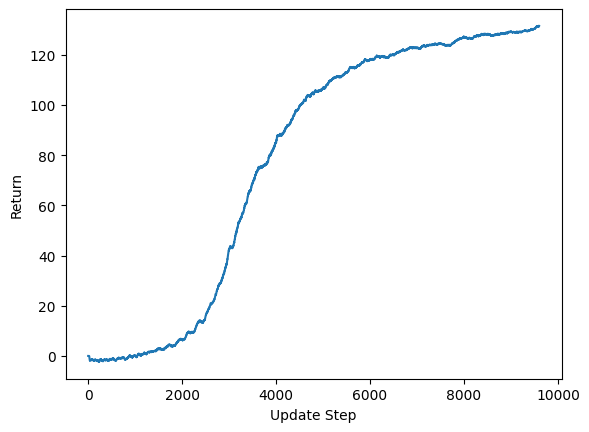

In [33]:
t0 = time.time()
out = jax.block_until_ready(train_jit(rng))
print(f"train time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

In [ ]:
# save network params
import pickle
with open("../results/ppo_params.pkl", "wb") as f:
    pickle.dump(out["runner_state"][0].params, f)

### evaluate enviroment

MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_309099/3173448777.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


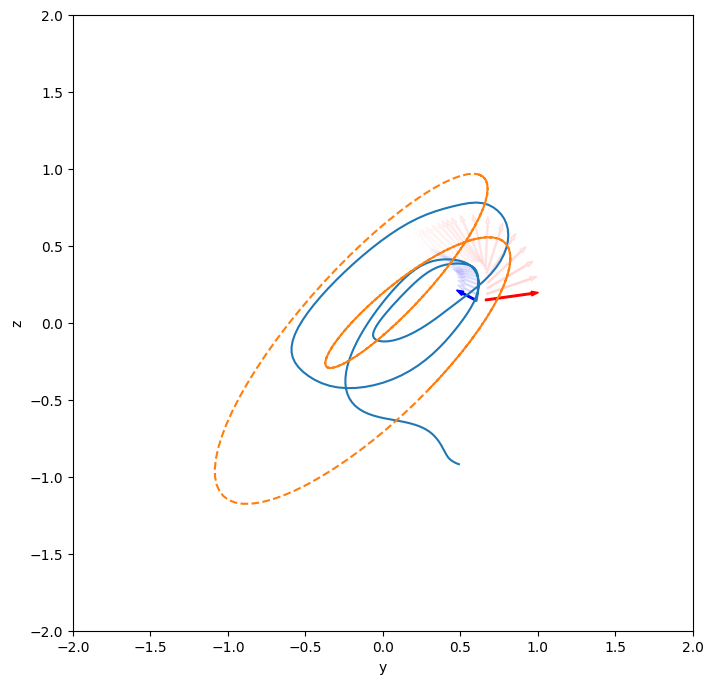

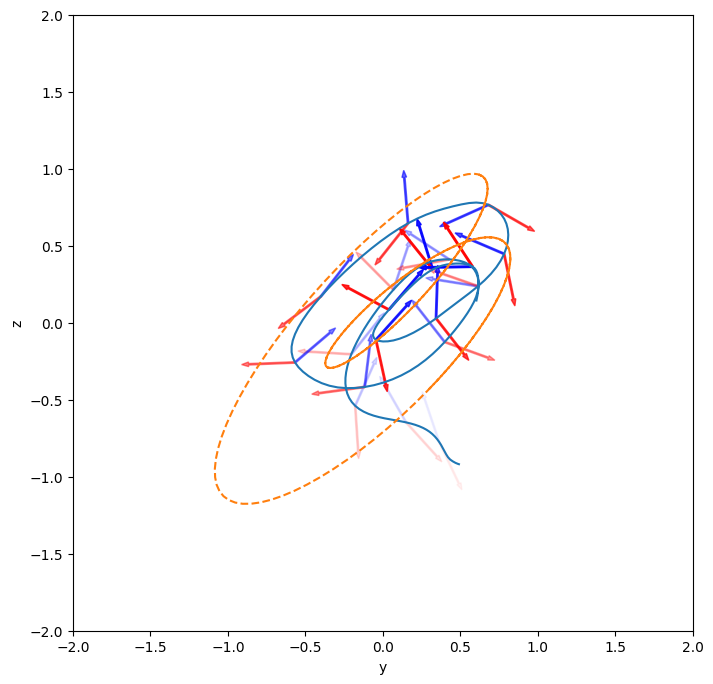

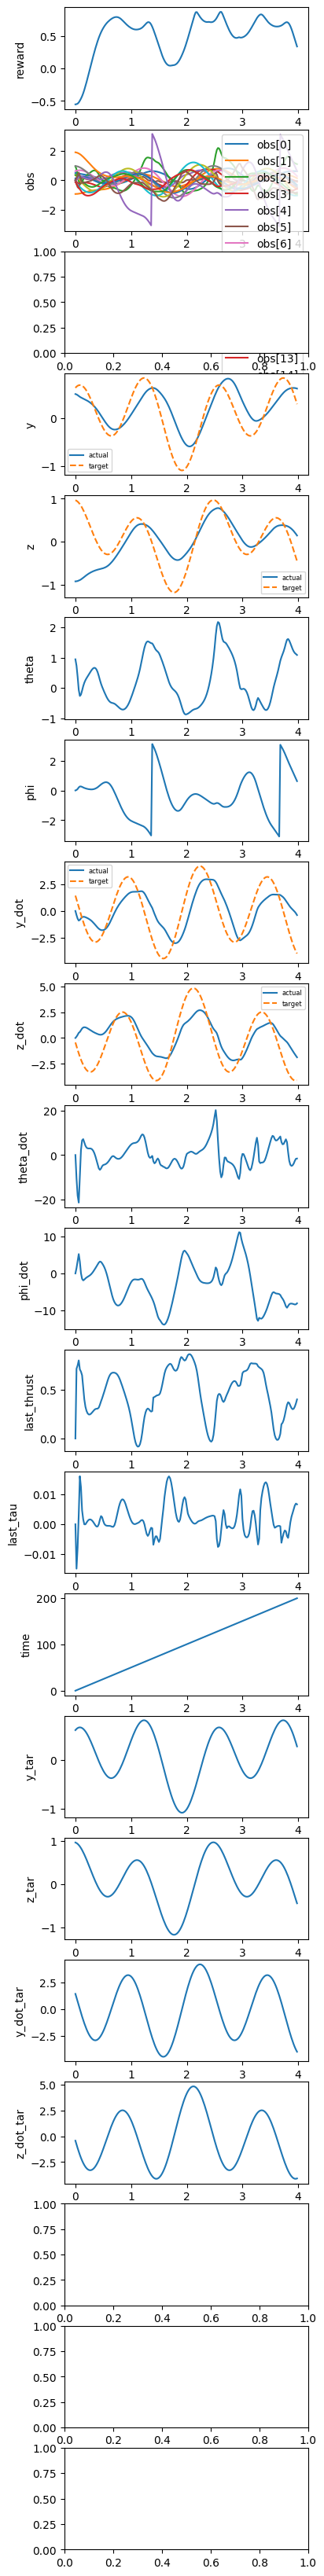

In [34]:
rng = jax.random.PRNGKey(1)
env = Quad2D()
apply_fn = out['runner_state'][0].apply_fn
params= out['runner_state'][0].params
def policy(obs, rng):
    return apply_fn(params, obs)[0].mean()
env.reset(rng)
# test policy
test_env(env, policy=policy)